# Lookup table inversion
## Using exact solution values
### Two layer model conductivity

In [1]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
from scipy.constants import mu_0

### Define the geometry of device

In [2]:
# Define Dualem-482 geometry

offsets = np.array([2, 4, 8]) # in meters
height = -0.10 # meters height From ground surface to center of coils
rad = 0.08 # Define radius of coil (8 cm)

# Source and receivers geometry

# For HCP
Hsource = [-rad, rad, -rad, rad, height, height]
Hreceivers = [offsets-rad, offsets+rad,
              np.ones(3)*-rad, np.ones(3)*rad, height, height]

# For VCP
Vsource = [0, 0, height, 90, 0]
Vreceivers = [offsets, offsets*0, height, 90, 0]

# For PRP
Psource = [0, 0, height]
Preceivers = [offsets+0.1, offsets*0, height]

# Frequency
freq = 9000

### Define the properties of the models of the lookup table

In [3]:
# sampling of conductivities
nsl = 50

s0 = -3 # minimum conductivity in S/m
s1 = -0.5 # maximum conductivity in S/m
# conductivities array
conds = np.logspace(s0, s1, nsl)

# Sampling of 1st layer thickness
th0 = 0.1 # minimum thickness in m
th1 = 9   # maximum thickness in m
# thickness array
thicks = np.linspace(th0, th1, nsl)

### Define forward function that provides values of quadrature for each geometry

In [4]:
def EMforward(sigma1, sigma2, thicks1):
    time.sleep(0.01)
    
    res =[2e14, 1/sigma1, 1/sigma2]
    depth=[0, thicks1]

    # Compute fields
    HCP_Hs = empymod.loop(Hsource, Hreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depth, res, freq, ab=64, xdirect=None, verb=0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[2e14], freqtime=freq, ab=66, verb=0)

    Q_HCP = -np.imag(HCP_Hs/HCP_Hp)
    Q_VCP = np.imag(VCP_Hs/VCP_Hp)
    Q_PRP = np.imag(PRP_Hs/PRP_Hp)
    
    P_HCP = -np.real(HCP_Hs/HCP_Hp)
    P_VCP = np.real(VCP_Hs/VCP_Hp)
    P_PRP = np.real(PRP_Hs/PRP_Hp)
    
    return np.hstack((Q_HCP, Q_VCP, Q_PRP, P_HCP, P_VCP, P_PRP))

### Calculate the solutions for all the models

In [5]:
startTime = time.time()

Qexact = Parallel(n_jobs=-1,verbose=1)(delayed(EMforward)(sigma1, sigma2, thick1) \
                                       for sigma1 in conds for sigma2 in conds for thick1 in thicks)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 2976 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 5776 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 9376 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 13776 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 18976 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 24976 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 31776 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 39376 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 47776 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 56976 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 66976 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 77776 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 89376 t

Execution time in seconds: 484.38438749313354


[Parallel(n_jobs=-1)]: Done 125000 out of 125000 | elapsed:  8.1min finished


### Functions to search model in lookup table

In [6]:
def gridsearch(Qdata):
    err = 1
    indx=0
    for i in range(np.shape(Qexact)[0]):
        nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
        merr = np.log(np.sqrt(np.sum(nZdiff)))
        if merr < err:
            indx = i
            err = merr.copy()
   # print(nZdiff)
   # print(merr)
    return indx

def invert(index):
    for i in range(len(conds)):
        for j in range(len(conds)):
            for k in range(len(thicks)):
                idx = k + j*nsl + i*nsl**2
                if index == idx:
                    model = np.array([conds[i], conds[j], thicks[k]])
                    return model

### Create a two layered 2D section with calculated solutions

In [7]:
# parameters for the synthetic model

nlayer = 2 # number of layer
npos = 20 # number of sampling positions

sig_ini = [conds[40], conds[10]]
sigmas = np.ones((npos, nlayer))*sig_ini

x = np.linspace(0, 20, npos)
thk1 = thicks[20:40]    # wave

depths = np.zeros((npos, nlayer))
depths[:,1] = thk1

In [8]:
def PlotModel(sigmas, depth):
    # Arrays for plotting
    depthmax=10
    ny = 50
    y = np.linspace(0, depthmax, ny)
    sigy = np.zeros((npos, ny))

    # Conductivities array to be plotted
    for i in range(npos):
        y1=0
        while y[y1] <= depth[i, 1]:
            sigy[i, y1] = sigmas[i, 0]
            y1 += 1
            y2=y1
        sigy[i, y2:] = sigmas[i, 1]
    
    fig, ax = plt.subplots()
    pos = ax.imshow(sigy.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], 
                    vmin = np.min(conds), vmax=np.max(conds) )
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Conductivity [S/m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')


Text(0.5, 1.0, 'True Model')

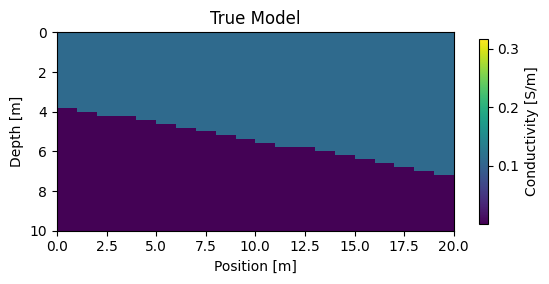

In [9]:
PlotModel(sigmas, depths)
plt.title('True Model')

In [10]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data=[]

for i in range(npos):
    model_i = np.hstack((sigmas[i], depths[i][1]))# True model 
    model.append(model_i)
    data.append(EMforward(sigmas[i][0], sigmas[i][1], depths[i][1])) # creating data
    
# Relative error array
#error = 1e-1 # introduce here the error you want to test
#relativeError = np.ones_like(data[0]) * error

In [11]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):   
    dataE = np.array(data[i]).copy()
    #dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = invert(gridsearch(dataE))
    
    model_est_list.append(model_est)

# Model estimation array  
model_est_arr = np.array(model_est_list)

/tmp/ipykernel_2087/3370081031.py:6: RuntimeWarning: divide by zero encountered in log
  merr = np.log(np.sqrt(np.sum(nZdiff)))


In [12]:
sigmas_est = model_est_arr[:,0:2]
depths_est = depths.copy()
depths_est[:,1] = model_est_arr[:,2]

Text(0.5, 1.0, 'Estimated Model')

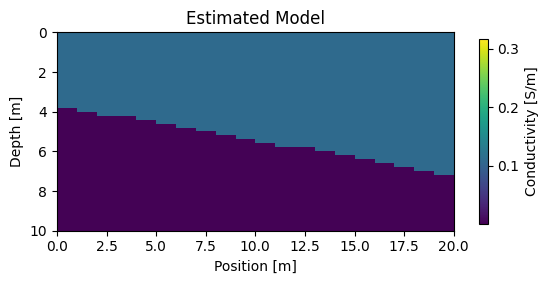

In [13]:
PlotModel(sigmas_est, depths_est)
plt.title('Estimated Model')

/tmp/ipykernel_2087/2561863205.py:13: RuntimeWarning: divide by zero encountered in log
  merr = np.log((np.sqrt(np.sum(nZdiff))))
/tmp/ipykernel_2087/2561863205.py:14: RuntimeWarning: divide by zero encountered in log
  merr_arr.append(np.log(np.sqrt(np.sum(nZdiff))))


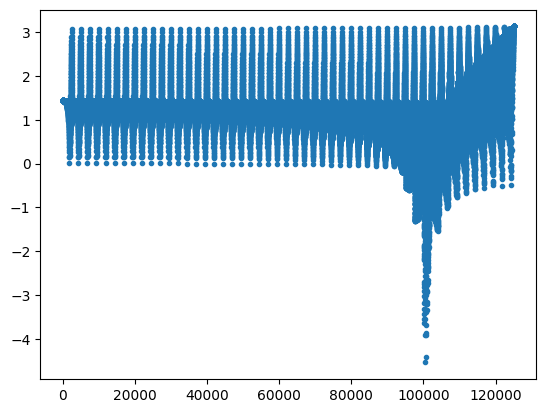

In [14]:
# Check if error is minima

sigma1_true = model[11][0]
sigma2_true = model[11][1]
thick1_true = model[11][2]

Qdata = EMforward(sigma1_true, sigma2_true, thick1_true)

err=1
merr_arr=[]
for i in range(np.shape(Qexact)[0]):
    nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
    merr = np.log((np.sqrt(np.sum(nZdiff))))
    merr_arr.append(np.log(np.sqrt(np.sum(nZdiff))))
    if merr < err:
        indx = i
        err = merr.copy()
        
plt.plot(merr_arr, '.')
plt.scatter(indx, np.min(merr_arr), c='r')
plt.scatter(indx, err, c='g')

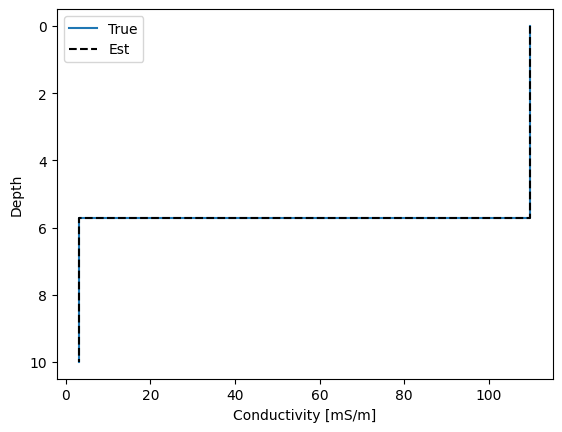

In [15]:
est_model = invert(indx)
plt.figure()
depth_true = np.array([0, thick1_true, 10])
depth_est = np.array([0, est_model[2], 10])
sigma_true = np.array([sigma1_true, sigma2_true, sigma2_true])*1000
sigma_est = np.array([est_model[0], est_model[1], est_model[1]])*1000
plt.step(sigma_true, depth_true, label='True')
plt.step(sigma_est, depth_est, '--k' , label='Est')
plt.legend()
plt.xlabel('Conductivity [mS/m]')
plt.ylabel('Depth')
ax = plt.gca()
ax.invert_yaxis()

In [16]:
merr_arr = np.reshape(merr_arr, (250,500))

In [17]:
linea = int(indx/(500))
fila = int((indx/(500) - linea)*500)

Text(0.5, 1.0, 'Error space')

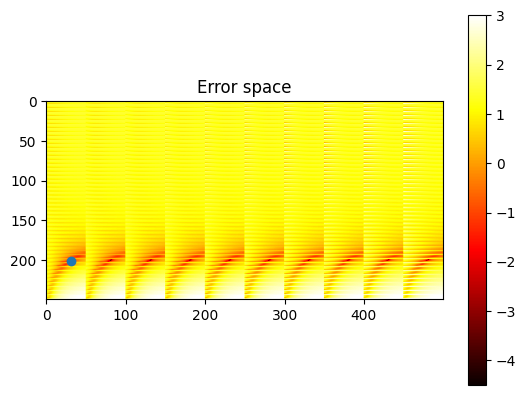

In [18]:
# Plot solutions space
fig, ax = plt.subplots()
pos=ax.imshow(merr_arr,cmap='hot',vmin=-4.5, vmax=3)
pos1=ax.scatter(fila,linea)
fig.colorbar(pos,ax=ax)
plt.title('Error space')

Text(0.5, 1.0, 'True Model')

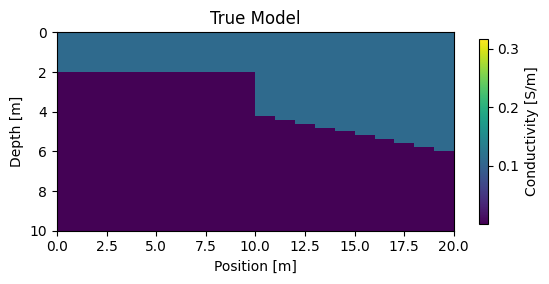

In [19]:
# parameters for the synthetic model

nlayer = 2 # number of layer
npos = 20 # number of sampling positions

sig_ini = [conds[40], conds[10]]
sigmas = np.ones((npos, nlayer))*sig_ini

x = np.linspace(0, 20, npos)
thk1 = np.ones_like(x)*2   # wave
thk1[10:] += x[10:]/5

depths = np.zeros((npos, nlayer))
depths[:,1] = thk1

PlotModel(sigmas, depths)
plt.title('True Model')

In [20]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data=[]

for i in range(npos):
    model_i = np.hstack((sigmas[i], depths[i][1]))# True model 
    model.append(model_i)
    data.append(EMforward(sigmas[i][0], sigmas[i][1], depths[i][1])) # creating data
    
# Relative error array
#error = 1e-1 # introduce here the error you want to test
#relativeError = np.ones_like(data[0]) * error

In [21]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):   
    dataE = np.array(data[i]).copy()
    #dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = invert(gridsearch(dataE))
    
    model_est_list.append(model_est)

# Model estimation array  
model_est_arr = np.array(model_est_list)

Text(0.5, 1.0, 'Estimated Model')

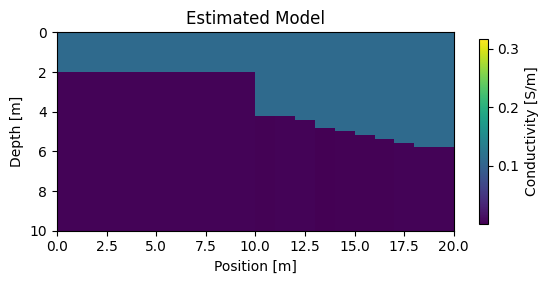

In [22]:
sigmas_est = model_est_arr[:,0:2]
depths_est = depths.copy()
depths_est[:,1] = model_est_arr[:,2]

PlotModel(sigmas_est, depths_est)
plt.title('Estimated Model')

In [23]:
# Check if chosen is error minima

# Let's try with the first position

sigma1_true = model[19][0]
sigma2_true = model[19][1]
thick1_true = model[19][2]

Qdata = EMforward(sigma1_true, sigma2_true, thick1_true)

err=1
merr_arr=[]
for i in range(np.shape(Qexact)[0]):
    nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
    merr = (np.log10(np.sqrt(np.sum(nZdiff))))
    merr_arr.append(np.log10(np.sqrt(np.sum(nZdiff))))
    if merr < err:
        indx = i
        err = merr.copy()

Text(0, 0.5, 'Log error')

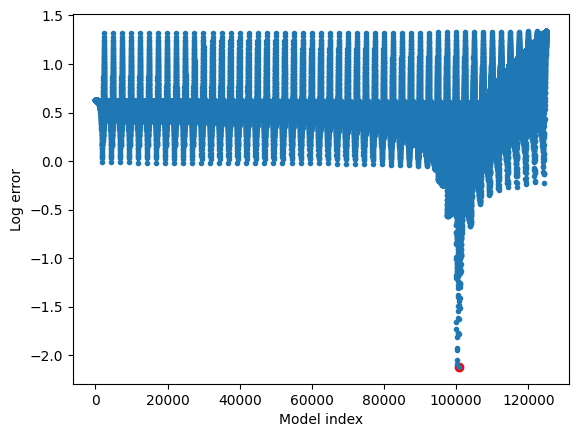

In [24]:
plt.plot(merr_arr, '.')
plt.scatter(indx, np.min(merr_arr), c='r')
#plt.scatter(indx, err, c='g')
plt.xlabel('Model index')
plt.ylabel('Log error')

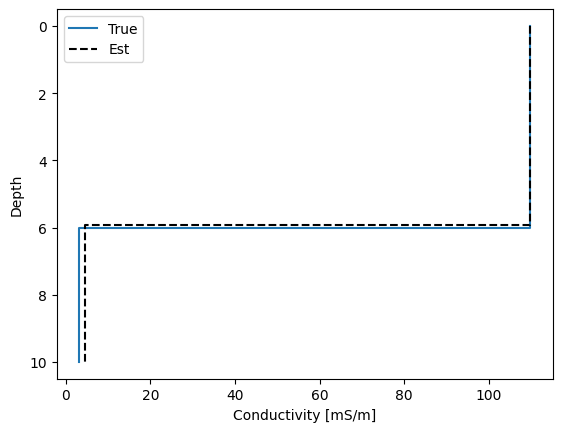

In [25]:
est_model = invert(indx)

plt.figure()
depth_true = np.array([0, thick1_true, 10])
depth_est = np.array([0, est_model[2], 10])
sigma_true = np.array([sigma1_true, sigma2_true, sigma2_true])*1000
sigma_est = np.array([est_model[0], est_model[1], est_model[1]])*1000
plt.step(sigma_true, depth_true, label='True')
plt.step(sigma_est, depth_est, '--k' , label='Est')
plt.legend()
plt.xlabel('Conductivity [mS/m]')
plt.ylabel('Depth')
ax = plt.gca()
ax.invert_yaxis()

Text(0.5, 1.0, 'Error space')

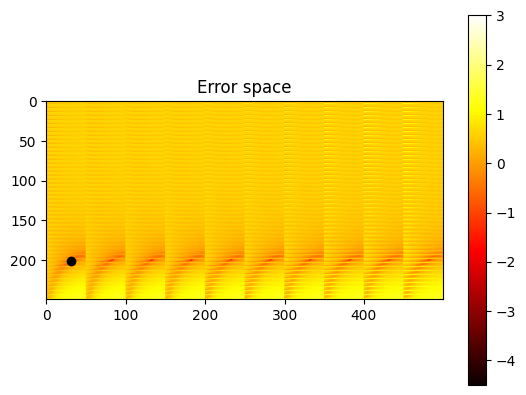

In [26]:
ymin = int(indx/(500))
xmin = int((indx/(500) - linea)*500)

merr_arr = np.reshape(merr_arr, (250,500))

# Plot solutions space
fig, ax = plt.subplots()
pos=ax.imshow(merr_arr,cmap='hot',vmin=-4.5, vmax=3)
pos1=ax.scatter(fila,linea,color='k')
fig.colorbar(pos,ax=ax)
plt.title('Error space')

# make contour map

Text(0.5, 1.0, 'Log of error')

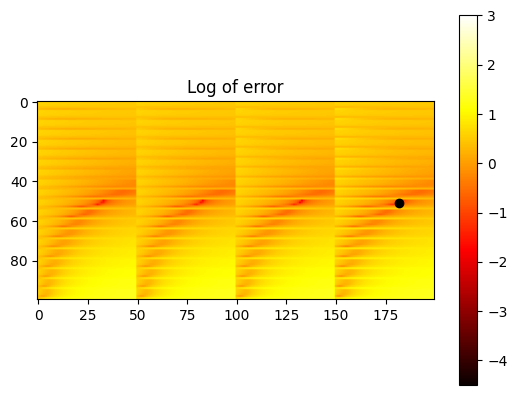

In [237]:
# Plot solutions space zoom in
fig, ax = plt.subplots()
pos=ax.imshow(merr_arr[150:,:200],cmap='hot',vmin=-4.5, vmax=3)
pos1=ax.scatter(xmin, ymin-150, color='k')
fig.colorbar(pos,ax=ax)
plt.title('Log of error')